In [45]:
import numpy as npcscssc
import pandas as pd
import matplotlib.pyplot as plt
import scanpy
import scanpy.api as sc
import numpy as np

import random
import sklearn
import scipy.sparse

from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Activation
from keras import regularizers
from sklearn.model_selection import KFold

import os.path as path
import os
from pathlib import Path
import sys
import wget

from IPython.display import display, HTML

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option("display.max_rows",120)

Using TensorFlow backend.


## Load 10x 68k pbmc dataset and put in dataframe `pdf`

In [2]:
#reads 10x dataset, takes ~30s
pbmc = sc.read_10x_mtx('./hg19/', var_names='gene_symbols', make_unique=True, cache=False, gex_only=True)

In [3]:
pdf = pd.DataFrame(pbmc.X.todense(), columns=pbmc.var['gene_ids'].values)
pdf.head()

,ENSG00000243485,ENSG00000237613,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000237683,ENSG00000239906,ENSG00000241599,ENSG00000228463,ENSG00000237094,...,ENSG00000217792,ENSG00000268276,ENSG00000148828,ENSG00000215700,ENSG00000215699,ENSG00000215635,ENSG00000268590,ENSG00000251180,ENSG00000215616,ENSG00000215611
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
cytoseq= pd.read_csv('cytoseq_ensembl.csv' )
cytoseq.head()

,gene,ensembl,probe
0,CD19,ENSG00000177455,CCAATCATGAGGAAGATGCA
1,BAFF-MS4A1,ENSG00000156738,GATTCCTCTCCAAACCCATG
2,CD20,ENSG00000102524,AGGTGGAAAAATAGATGCCAGTC
3,TCL1A,ENSG00000100721,CAGGACTCAGAAGCCTCTGG
4,TACI-TAC1,ENSG00000006128,TGTGTCAGCTACTGCGGAAA


In [9]:
# checks which genes from cytoseq data are in the 10x 68k pbmc data

good_cytoseq = []
bad_cytoseq = []
for gene in cytoseq['ensembl']:
    if gene in pdf.columns.values:
        good_cytoseq.append(gene)
    else: bad_cytoseq.append(gene)

print(len(good_cytoseq), "cytoseq pbmc genes in 10x dataset")
print("Genes not found:")
print(bad_cytoseq)

92 cytoseq pbmc genes in 10x dataset
Genes not found:
['ENSG00000211898', 'ENSG00000211899', 'ENSG00000272398', 'ENSG00000276977', 'ENSG00000274739', 'ENSG00000276425']


## 10x PBMC data restricted to the 92 cytoseq genes

In [10]:
# makes a gene count matrix with only the cytoseq pbmc genes
pbmc_cytoseq = pdf[good_cytoseq]
pbmc_cytoseq.head()

,ENSG00000177455,ENSG00000156738,ENSG00000102524,ENSG00000100721,ENSG00000006128,ENSG00000139193,ENSG00000004468,ENSG00000111732,ENSG00000026103,ENSG00000196549,...,ENSG00000137462,ENSG00000164342,ENSG00000136869,ENSG00000187554,ENSG00000174130,ENSG00000196664,ENSG00000101916,ENSG00000239732,ENSG00000174123,ENSG00000111640
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
labels = pd.read_csv('./hg19/zheng17_bulk_lables.txt', header = None)
labelsdf = labels
unique_labels = np.unique(labels.values)
print('Unique labels: ', unique_labels)
labels = labels.values
print('Total number of labels:', len(labels))
labels

Unique labels:  ['CD14+ Monocyte' 'CD19+ B' 'CD34+' 'CD4+ T Helper2' 'CD4+/CD25 T Reg'
 'CD4+/CD45RA+/CD25- Naive T' 'CD4+/CD45RO+ Memory' 'CD56+ NK'
 'CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'Dendritic']
Total number of labels: 68579


array([['CD8+ Cytotoxic T'],
       ['CD8+/CD45RA+ Naive Cytotoxic'],
       ['CD4+/CD25 T Reg'],
       ...,
       ['CD8+ Cytotoxic T'],
       ['CD8+/CD45RA+ Naive Cytotoxic'],
       ['CD8+/CD45RA+ Naive Cytotoxic']], dtype=object)

In [99]:
# Puts the cell labels in one hot encoded categorical format for keras
label_id = {}
class_id = 0
for label in unique_labels:
    label_id[class_id] = label
    label_id[label] = class_id
    class_id +=1
        
numerical_labels = {}
numerical_labels = np.array(labelsdf[0].map(label_id))
categorical_labels = to_categorical(numerical_labels,num_classes=len(unique_labels))
categorical_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## PCA on all genes

In [34]:
# takes ~30s
pca2 = PCA(n_components=20)
pca2.fit(pdf)
pca_points2 = pca2.transform(pdf)
pca_x2 = pca_points2[:,:1,].flatten()
pca_y2 = pca_points2[:,1:2,].flatten()

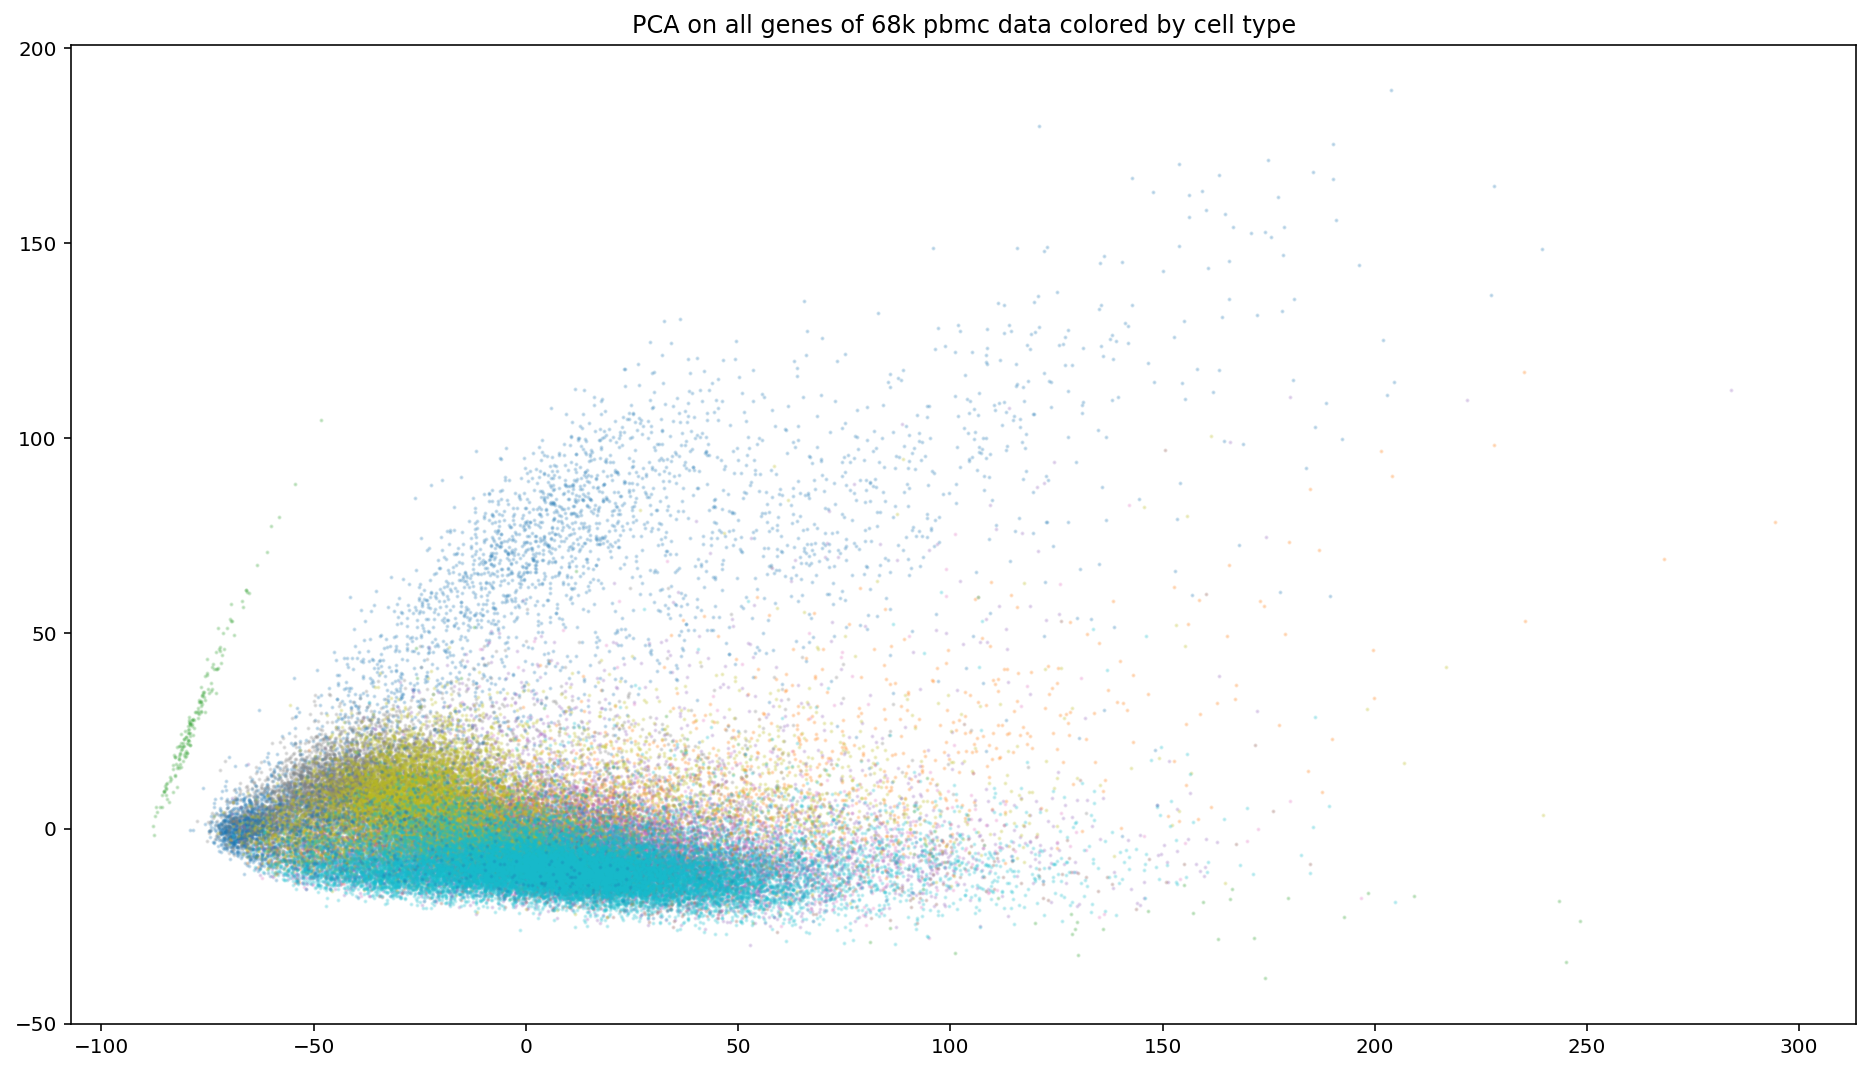

In [35]:
#plot PCA
plt.rcParams["figure.figsize"] = [16,9]

for label_type in unique_labels:
    label_indexes = labelsdf[labelsdf == label_type].dropna().index.values
    plt.scatter(pca_x2[label_indexes],pca_y2[label_indexes], s = 1, alpha = 0.2)
plt.title('PCA on all genes of 68k pbmc data colored by cell type') #get the title property handler
plt.show()

## PCA on cytoseq genes

In [36]:
np.shape(np.mean(np.log1p(pbmc_cytoseq.values), 0  ))

(92,)

In [37]:
pbmc_cytoseq_log = np.log1p(pbmc_cytoseq.values) - np.mean(np.log1p(pbmc_cytoseq.values), 0  )

pca92 = PCA(n_components=20)
pca92.fit(pbmc_cytoseq_log)
pca_points1 = pca92.transform(pbmc_cytoseq_log)
pca_x1 = pca_points1[:,:1,].flatten()
pca_y1 = pca_points1[:,1:2,].flatten()

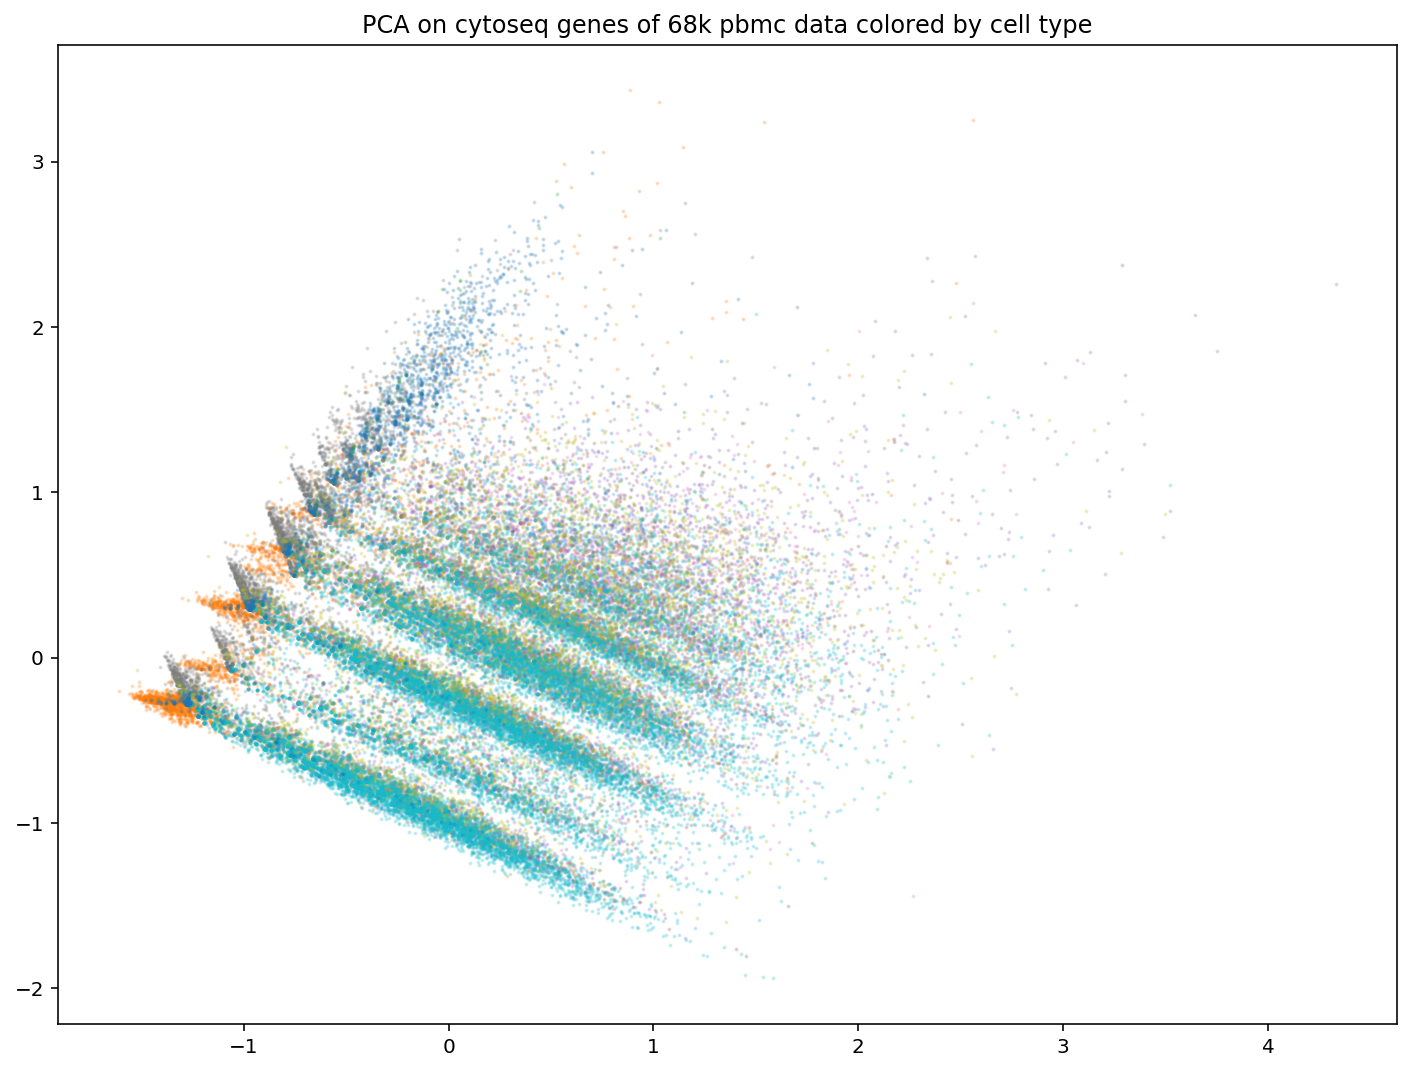

In [38]:

plt.rcParams["figure.figsize"] = [12,9]

for label_type in unique_labels:
    label_indexes = labelsdf[labelsdf == label_type].dropna().index.values
    plt.scatter(pca_x1[label_indexes],pca_y1[label_indexes], s = 1, alpha = 0.2)
plt.title('PCA on cytoseq genes of 68k pbmc data colored by cell type') #get the title property handler
plt.show()    


In [39]:
pca92.explained_variance_ratio_

array([0.17375305, 0.13062421, 0.09878169, 0.07526264, 0.06764739,
       0.05362765, 0.04999896, 0.04068079, 0.03857988, 0.03226503,
       0.02393454, 0.02197644, 0.02056808, 0.01894914, 0.01165676,
       0.0110465 , 0.01036473, 0.00957473, 0.00903047, 0.00862914])

In [42]:
pca92.components_[0]

array([-1.23111745e-02, -5.29610477e-02, -3.21259117e-03, -9.00700837e-02,
       -2.24004561e-12,  2.58150578e-01,  1.04977086e-03,  5.96042540e-08,
        6.05813647e-03,  1.08040967e-05,  2.32500388e-04,  9.95272421e-06,
        1.55169144e-01, -1.33748027e-03,  1.28047215e-03,  2.36911438e-02,
        1.94421620e-03, -6.24281587e-03,  1.31563691e-04,  5.16764179e-04,
        3.55188316e-03,  1.39206666e-02,  1.20336702e-02, -2.09799246e-03,
        3.83513384e-02, -1.63438404e-03,  1.43160997e-02, -3.20580485e-03,
        2.57033738e-04, -9.19935483e-05,  0.00000000e+00, -1.66044722e-03,
       -1.49154617e-03, -2.99046412e-02,  5.97754540e-03, -2.05835775e-02,
       -5.72935166e-03,  1.22434972e-03,  1.05280928e-01, -3.01012915e-04,
       -6.15532976e-03, -6.94996197e-05,  0.00000000e+00, -1.25535344e-05,
        1.33592530e-05,  0.00000000e+00, -8.40390348e-05, -1.70753826e-03,
       -2.41785077e-03,  9.42179747e-03,  6.32785916e-01,  4.72286999e-01,
        7.45508075e-02,  

#### Plotting higher order principal components - still doesn't separate well

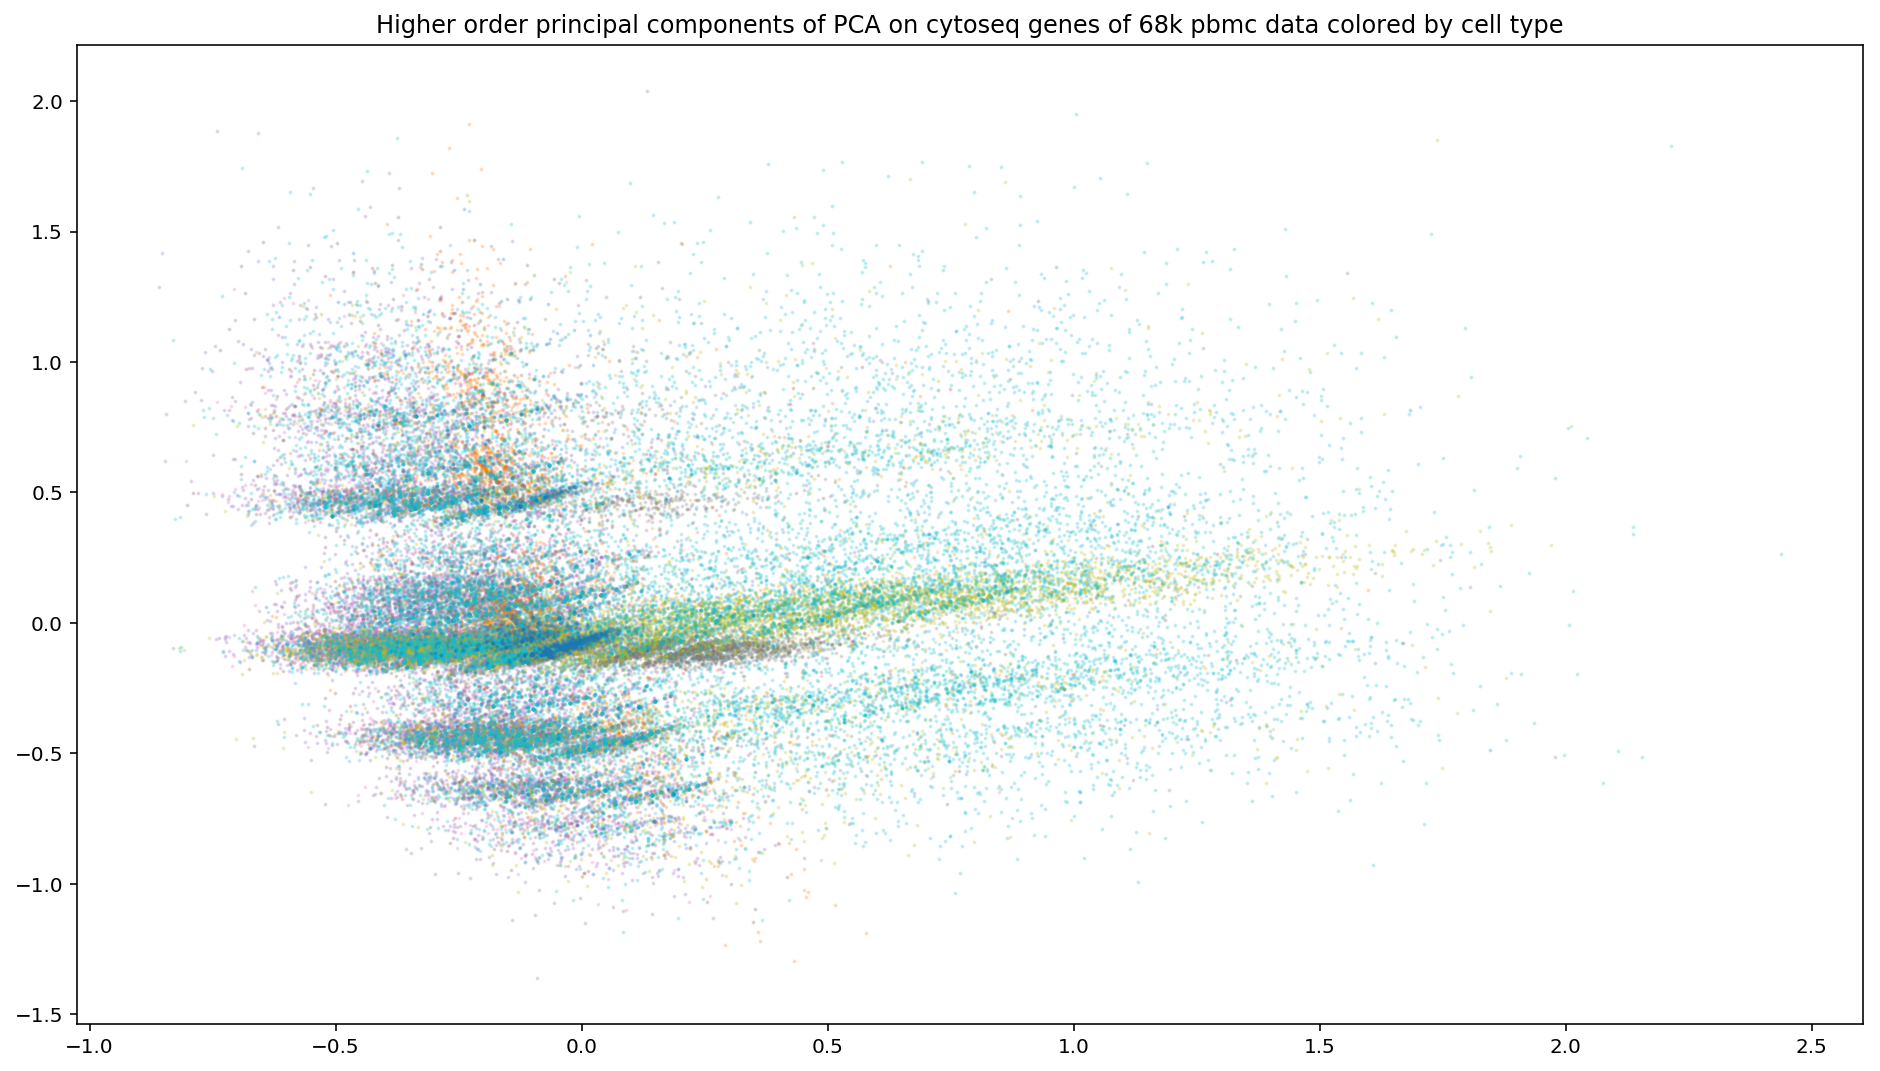

In [46]:
pca_z1 = pca_points1[:,6].flatten()
pca_y1 = pca_points1[:,5].flatten()

plt.rcParams["figure.figsize"] = [16,9]
pca92.components_[0]

for label_type in unique_labels:
    label_indexes = labelsdf[labelsdf == label_type].dropna().index.values
    plt.scatter(pca_y1[label_indexes],pca_z1[label_indexes], s = 1, alpha = 0.2)
plt.title('Higher order principal components of PCA on cytoseq genes of 68k pbmc data colored by cell type') 
plt.show()    


# Now let's do celltyper

In [50]:
# Loading all genes
# Load the cell by gene data as a sparse matrix, then transpose to get a (68579, 32738) matrix
X = pdf.values
n_genes = np.shape(X)[1]
n_cells = np.shape(X)[0]
print('Loaded (cells,gene) data is a matrix of shape:', np.shape(X))

Loaded (cells,gene) data is a matrix of shape: (68579, 32738)


In [55]:
### Model is a dict that holds our different keras models as we make them
model = {}

In [54]:
# splits the data in half and get two list of indices: `train_indices` and `test_indices`
train_indices = np.array(range(1,n_cells,2)) 
test_indices = np.array(range(0,n_cells,2))
print("TRAIN INDEX:", train_indices,'\n', "TEST INDEX:", test_indices)

BATCH_SIZE = 10000 # batchsize = half of the data
EPOCHS = 10
STEPS_PER_EPOCH = len(train_indices) // BATCH_SIZE

TRAIN INDEX: [    1     3     5 ... 68573 68575 68577] 
 TEST INDEX: [    0     2     4 ... 68574 68576 68578]


In [60]:
# model['allgenes']  is a single layer classifier with ridge regression that uses the full 10x data

output_dim = len(np.unique(labels))
input_dim = np.shape(X)[1]
model['allgenes'] = Sequential()
model['allgenes'].add(Dense(100, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model['allgenes'].add(Dense(output_dim, input_dim=100, activation='softmax'))
model['allgenes'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [107]:
#Train a single layer classifier with ridge regression for 10 epocks
print ('RIDGE CLASSIFIER ON FULL DATASET')
history = model['allgenes'].fit(
        x = X[train_indices],
        y = categorical_labels[train_indices],
        validation_data=(X[test_indices], categorical_labels[test_indices]),
        validation_steps=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        steps_per_epoch= STEPS_PER_EPOCH)

RIDGE CLASSIFIER ON FULL DATASET
Train on 34289 samples, validate on 34290 samples
Epoch 1/10
3/3 [==============================] - 28s 9s/step - loss: 126.4988 - acc: 0.4008 - val_loss: 87.9171 - val_acc: 0.5672
Epoch 2/10
3/3 [==============================] - 34s 11s/step - loss: 73.6325 - acc: 0.5504 - val_loss: 49.8799 - val_acc: 0.5909
Epoch 3/10
3/3 [==============================] - 31s 10s/step - loss: 42.8324 - acc: 0.6144 - val_loss: 33.6137 - val_acc: 0.6434
Epoch 4/10
3/3 [==============================] - 29s 10s/step - loss: 34.1117 - acc: 0.6442 - val_loss: 37.3882 - val_acc: 0.6644
Epoch 5/10
3/3 [==============================] - 29s 10s/step - loss: 37.1602 - acc: 0.6624 - val_loss: 34.3078 - val_acc: 0.6519
Epoch 6/10
3/3 [==============================] - 28s 9s/step - loss: 31.3904 - acc: 0.6715 - val_loss: 25.5686 - val_acc: 0.6773
Epoch 7/10
3/3 [==============================] - 29s 10s/step - loss: 22.6028 - acc: 0.6822 - val_loss: 17.8728 - val_acc: 0.6934
E

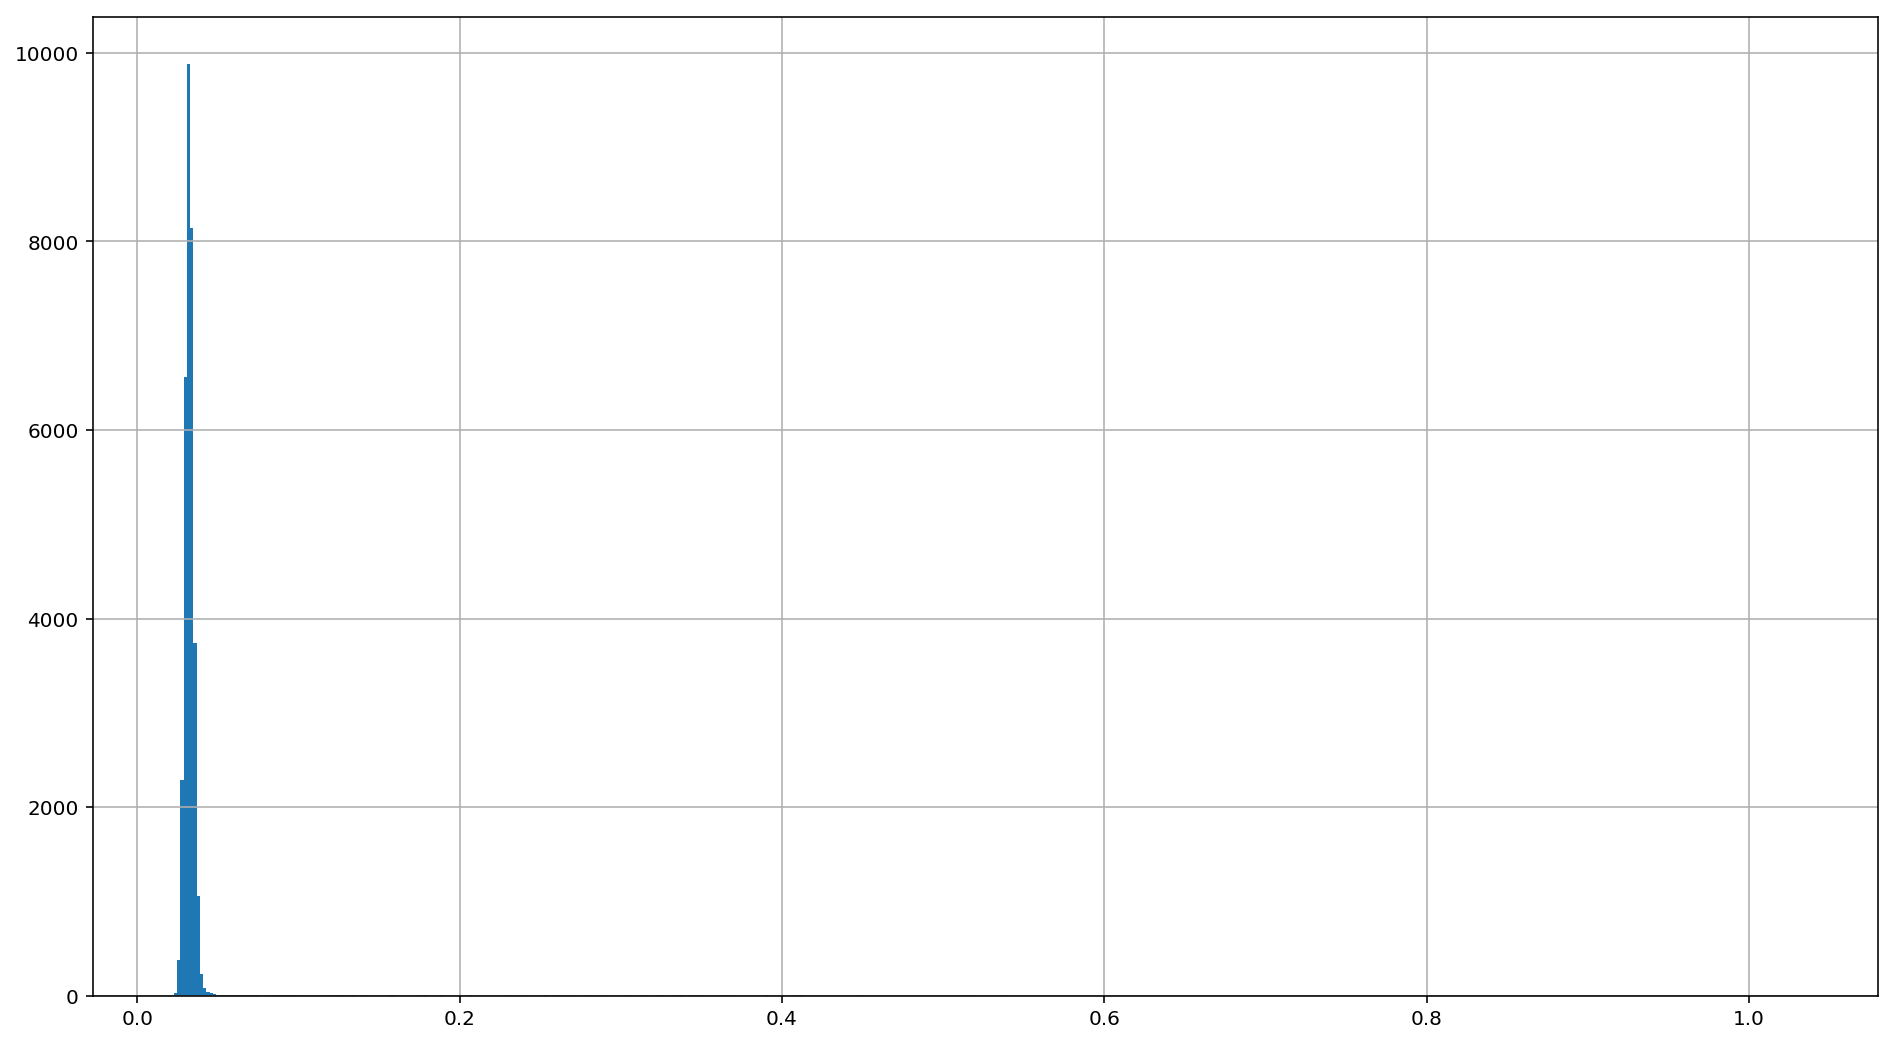

In [111]:
pd.DataFrame(model['allgenes'].get_weights()[0]).abs().sum(axis=1).hist(bins=500)

In [114]:
weights_allgenes = pd.DataFrame(model['allgenes'].get_weights()[0]).abs().sum(axis=1).sort_values(ascending=False)
weights_allgenes.head(10)

4046     1.029793
9798     0.942121
26824    0.910671
31075    0.850423
23794    0.696232
10677    0.680409
1964     0.672483
30933    0.637844
19154    0.619073
13302    0.594794
dtype: float32

# Now train on just the cytoseq genes

In [122]:
# Loading cytoseq genes
# Load the cell by gene data as a sparse matrix, then transpose to get a (68579, 92) matrix
X92 = pbmc_cytoseq.values
n_genes = np.shape(X92)[1]
n_cells = np.shape(X92)[0]
print('Loaded (cells,gene) data is a matrix of shape:', np.shape(X92))

Loaded (cells,gene) data is a matrix of shape: (68579, 92)


In [128]:
output_dim = len(unique_labels)
input_dim = np.shape(X92)[1]
model['cytoseq92'] = Sequential()
model['cytoseq92'].add(Dense(100, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model['cytoseq92'].add(Dense(output_dim, input_dim=100, activation='softmax'))
model['cytoseq92'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

    
#Train each of the 5 taxonomy rank logistic regresison classifier models
print ('CLASSIFIER WITH 92 CYTOSEQ GENES')
history = model['cytoseq92'].fit(
        x = X92[train_indices],
        y = categorical_labels[train_indices],
    validation_data=(X92[test_indices], categorical_labels[test_indices]),
    validation_steps=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    steps_per_epoch= 30*STEPS_PER_EPOCH)

CLASSIFIER WITH 92 CYTOSEQ GENES
Train on 34289 samples, validate on 34290 samples
Epoch 1/10
90/90 [==============================] - 5s 58ms/step - loss: 6.7785 - acc: 0.3887 - val_loss: 3.8108 - val_acc: 0.4798
Epoch 2/10
90/90 [==============================] - 5s 56ms/step - loss: 2.4162 - acc: 0.4964 - val_loss: 1.6879 - val_acc: 0.5071
Epoch 3/10
90/90 [==============================] - 5s 57ms/step - loss: 1.6105 - acc: 0.5105 - val_loss: 1.5561 - val_acc: 0.5206
Epoch 4/10
90/90 [==============================] - 5s 53ms/step - loss: 1.5275 - acc: 0.5240 - val_loss: 1.4978 - val_acc: 0.5335
Epoch 5/10
90/90 [==============================] - 5s 53ms/step - loss: 1.4785 - acc: 0.5375 - val_loss: 1.4571 - val_acc: 0.5468
Epoch 6/10
90/90 [==============================] - 5s 54ms/step - loss: 1.4417 - acc: 0.5459 - val_loss: 1.4244 - val_acc: 0.5516
Epoch 7/10
90/90 [==============================] - 5s 55ms/step - loss: 1.4121 - acc: 0.5493 - val_loss: 1.3983 - val_acc: 0.5539


## Gets the total counts of each gene in 10x dataset

In [165]:
counts = pbmc_cytoseq.sum()
counts = counts.rename('counts')
counts_cytoseq = cytoseq.join(counts.rename('counts').to_frame(), on = 'ensembl').drop_duplicates()
counts_cytoseq.head()

,gene,ensembl,probe,counts
0,CD19,ENSG00000177455,CCAATCATGAGGAAGATGCA,964.0
1,BAFF-MS4A1,ENSG00000156738,GATTCCTCTCCAAACCCATG,4968.0
2,CD20,ENSG00000102524,AGGTGGAAAAATAGATGCCAGTC,1422.0
3,TCL1A,ENSG00000100721,CAGGACTCAGAAGCCTCTGG,7514.0
4,TACI-TAC1,ENSG00000006128,TGTGTCAGCTACTGCGGAAA,0.0


In [166]:
weights_cytoseq92 = pd.DataFrame(model['cytoseq92'].get_weights()[0]).abs().sum(axis=1).sort_values(ascending=False)
weights_cytoseq92 = weights_cytoseq92.rename('weight')
weights_cytoseq92 = weights_cytoseq92.to_frame()
weights_cytoseq92['ensembl'] = pbmc_cytoseq.columns[weights_cytoseq92.index]
weights_cytoseq92 = weights_cytoseq92.set_index('ensembl')

weights_cytoseq92.head()

,weight
ensembl,
ENSG00000180644,1.773341
ENSG00000156738,1.254963
ENSG00000198851,1.160852
ENSG00000172116,1.140802
ENSG00000167286,1.064499


In [167]:
counts_cytoseq = counts_cytoseq.join(weights_cytoseq92['weight'], on = 'ensembl').drop_duplicates()
counts_cytoseq = counts_cytoseq.sort_values(by=['weight'], ascending = False)
#swccytoseq.to_csv('ctyoseq_weights_counts_sorted.csv')
counts_cytoseq.head(25)

,gene,ensembl,probe,counts,weight
60,PRF1,ENSG00000180644,TCAGGGCTGGTCTTTTAGGA,16764.0,1.773341
1,BAFF-MS4A1,ENSG00000156738,GATTCCTCTCCAAACCCATG,4968.0,1.254963
57,CD3E,ENSG00000198851,GCATGTAAGTTGTCCCCCAT,71864.0,1.160852
59,CD8B,ENSG00000172116,TGCTTAACCCATGGATCCTG,21157.0,1.140802
56,CD3D,ENSG00000167286,GGAGTCTTCTGCTTTGCTGG,92330.0,1.064499
58,CD8A,ENSG00000153563,ATGGTACAAGCAATGCCTGC,12773.0,1.031315
62,CD4,ENSG00000010610,TCCTCCAGACCATTCAGGAC,3894.0,0.995281
3,TCL1A,ENSG00000100721,CAGGACTCAGAAGCCTCTGG,7514.0,0.860522
37,IGFBP7,ENSG00000163453,GGTGAAGGTGCCGAGCTATA,3765.0,0.749861
67,CCR7,ENSG00000126353,ACTCAGCTCTTGGCTCCACT,16933.0,0.749125


# Now train a model restricted to top 25 genes by weight and see how it goes

In [168]:
top25 = np.unique(counts_cytoseq.head(25)['ensembl'].values)

In [169]:
pbmc_cytoseq25 = pdf[top25]
pbmc_cytoseq25.head()

,ENSG00000010610,ENSG00000026103,ENSG00000026508,ENSG00000081237,ENSG00000089692,ENSG00000100721,ENSG00000105329,ENSG00000111640,ENSG00000126353,ENSG00000139193,...,ENSG00000163453,ENSG00000163508,ENSG00000167286,ENSG00000170458,ENSG00000172116,ENSG00000180644,ENSG00000183918,ENSG00000186810,ENSG00000188404,ENSG00000198851
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [176]:
# Load the cell by gene data as a sparse matrix, then transpose to get a (68579, 1037) matrix
X25 = pbmc_cytoseq25.values
n_genes = np.shape(X)[1]
n_cells = np.shape(X)[0]
print('Loaded (cells,gene) data is a matrix of shape:', np.shape(X))
print('Cell labels of length', len(labels))


Loaded (cells,gene) data is a matrix of shape: (68579, 22)
Cell labels of length 68579


In [180]:
output_dim = len(unique_labels)
input_dim = np.shape(X25)[1]
model['cytoseq25'] = Sequential()
model['cytoseq25'].add(Dense(100, input_dim=input_dim, activation='relu'))
model['cytoseq25'].add(Dense(output_dim, input_dim=100, activation='softmax'))
model['cytoseq25'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

    
print ('CLASSIFIER USING ONLY TOP 25 CYTOSEQ GENES')
history = model['cytoseq25'].fit(
        x = X25[train_indices],
        y = categorical_labels[train_indices],
    validation_data=(X25[test_indices], categorical_labels[test_indices]),
    validation_steps=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    steps_per_epoch= 30*STEPS_PER_EPOCH)

CLASSIFIER USING ONLY TOP 25 CYTOSEQ GENES
Train on 34289 samples, validate on 34290 samples
Epoch 1/10
90/90 [==============================] - 5s 53ms/step - loss: 1.7145 - acc: 0.4353 - val_loss: 1.3492 - val_acc: 0.5468
Epoch 2/10
90/90 [==============================] - 4s 49ms/step - loss: 1.2513 - acc: 0.5612 - val_loss: 1.1976 - val_acc: 0.5681
Epoch 3/10
90/90 [==============================] - 5s 50ms/step - loss: 1.1659 - acc: 0.5694 - val_loss: 1.1577 - val_acc: 0.5734
Epoch 4/10
90/90 [==============================] - 4s 49ms/step - loss: 1.1380 - acc: 0.5737 - val_loss: 1.1418 - val_acc: 0.5749
Epoch 5/10
90/90 [==============================] - 4s 50ms/step - loss: 1.1232 - acc: 0.5753 - val_loss: 1.1319 - val_acc: 0.5752
Epoch 6/10
90/90 [==============================] - 5s 50ms/step - loss: 1.1127 - acc: 0.5777 - val_loss: 1.1249 - val_acc: 0.5789
Epoch 7/10
90/90 [==============================] - 4s 49ms/step - loss: 1.1047 - acc: 0.5802 - val_loss: 1.1198 - val_ac

In [181]:
print ('CLASSIFIER USING ONLY TOP 25 CYTOSEQ GENES')
history = model['cytoseq25'].fit(
        x = X25[train_indices],
        y = categorical_labels[train_indices],
    validation_data=(X25[test_indices], categorical_labels[test_indices]),
    validation_steps=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    steps_per_epoch= 30*STEPS_PER_EPOCH)

CLASSIFIER USING ONLY TOP 25 CYTOSEQ GENES
Train on 34289 samples, validate on 34290 samples
Epoch 1/10
90/90 [==============================] - 4s 48ms/step - loss: 1.0850 - acc: 0.5841 - val_loss: 1.1097 - val_acc: 0.5810
Epoch 2/10
90/90 [==============================] - 4s 48ms/step - loss: 1.0815 - acc: 0.5850 - val_loss: 1.1087 - val_acc: 0.5817
Epoch 3/10
90/90 [==============================] - 4s 46ms/step - loss: 1.0784 - acc: 0.5856 - val_loss: 1.1080 - val_acc: 0.5814
Epoch 4/10
90/90 [==============================] - 5s 51ms/step - loss: 1.0756 - acc: 0.5864 - val_loss: 1.1075 - val_acc: 0.5810
Epoch 5/10
90/90 [==============================] - 4s 48ms/step - loss: 1.0732 - acc: 0.5871 - val_loss: 1.1074 - val_acc: 0.5803
Epoch 6/10
90/90 [==============================] - 4s 48ms/step - loss: 1.0709 - acc: 0.5884 - val_loss: 1.1073 - val_acc: 0.5798
Epoch 7/10
90/90 [==============================] - 5s 50ms/step - loss: 1.0688 - acc: 0.5888 - val_loss: 1.1072 - val_ac

In [182]:
weights25 = pd.DataFrame(model['cytoseq25'].get_weights()[0]).abs().sum(axis=1).sort_values(ascending=False)
weights25

13    31.026514
12    30.437626
4     29.600849
15    29.530581
1     29.321115
11    28.515425
0     27.112925
5     26.703518
10    25.786531
18    25.266197
19    23.360224
16    21.137257
8     20.135990
17    19.742483
9     18.475851
6     17.785532
20    15.658858
14    15.398113
2     15.241644
3     14.657847
21    14.614655
7     10.975467
dtype: float32

In [183]:
weights25 = pd.DataFrame(model['cytoseq25'].get_weights()[0]).abs().sum(axis=1).sort_values(ascending=False)
weights25

13    31.026514
12    30.437626
4     29.600849
15    29.530581
1     29.321115
11    28.515425
0     27.112925
5     26.703518
10    25.786531
18    25.266197
19    23.360224
16    21.137257
8     20.135990
17    19.742483
9     18.475851
6     17.785532
20    15.658858
14    15.398113
2     15.241644
3     14.657847
21    14.614655
7     10.975467
dtype: float32

In [184]:
weights25 = pd.DataFrame(model['cytoseq25'].get_weights()[0]).abs().sum(axis=1).sort_values(ascending=False)
weights25

13    31.026514
12    30.437626
4     29.600849
15    29.530581
1     29.321115
11    28.515425
0     27.112925
5     26.703518
10    25.786531
18    25.266197
19    23.360224
16    21.137257
8     20.135990
17    19.742483
9     18.475851
6     17.785532
20    15.658858
14    15.398113
2     15.241644
3     14.657847
21    14.614655
7     10.975467
dtype: float32

In [185]:
model

{'allgenes': <keras.engine.sequential.Sequential at 0x7f3b94e9f630>,
 'cytoseq92': <keras.engine.sequential.Sequential at 0x7f3b838fc978>,
 'cytoseq25': <keras.engine.sequential.Sequential at 0x7f3b6a180358>}